In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d kamal01/top-agriculture-crop-disease

Dataset URL: https://www.kaggle.com/datasets/kamal01/top-agriculture-crop-disease
License(s): CC0-1.0
100% 4.33G/4.33G [04:20<00:00, 20.0MB/s]
100% 4.33G/4.33G [04:20<00:00, 17.9MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/top-agriculture-crop-disease.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

In [ ]:
base_dir = '/content/Crop Diseases'

In [ ]:
# Create an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)  # Using 20% of data for validation

# Create training data generator
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='training')  # Set as training data

# Create validation data generator
validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation')  # Set as validation data

Found 10664 images belonging to 17 classes.
Found 2660 images belonging to 17 classes.


Classes: ['Potato___Healthy', 'Rice___Brown_Spot', 'Sugarcane_Bacterial Blight', 'Sugarcane_Healthy', 'Potato___Late_Blight', 'Potato___Early_Blight', 'Corn___Gray_Leaf_Spot', 'Wheat___Brown_Rust', 'Corn___Healthy', 'Corn___Northern_Leaf_Blight', 'Sugarcane_Red Rot', 'Corn___Common_Rust', 'Wheat___Yellow_Rust', 'Rice___Neck_Blast', 'Wheat___Healthy', 'Rice___Healthy', 'Rice___Leaf_Blast']


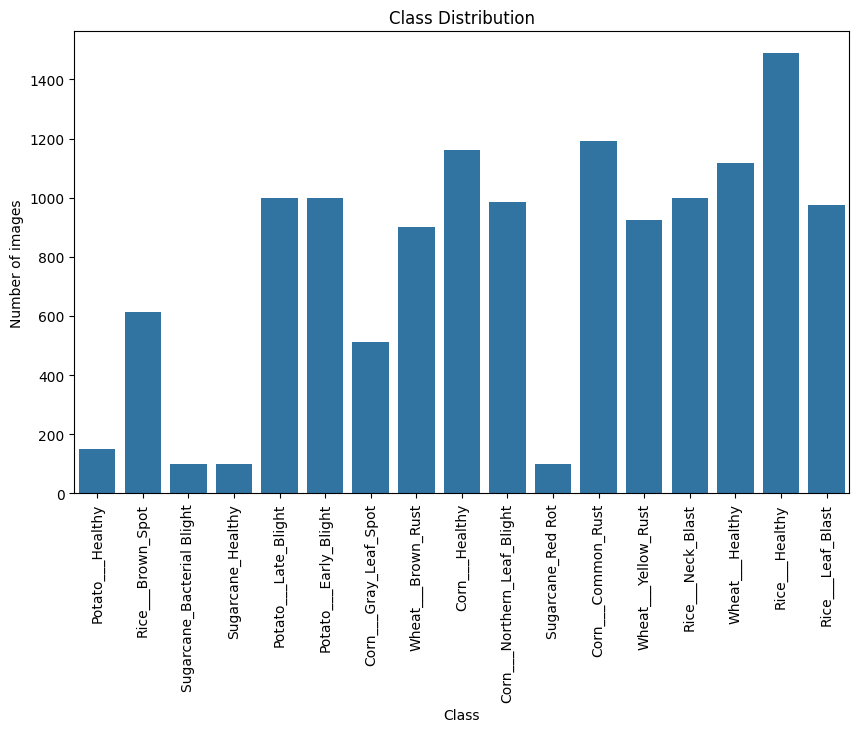

In [ ]:
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
print(f"Classes: {classes}")

# Count the number of images in each class
class_counts = {}
for cls in classes:
    class_dir = os.path.join(base_dir, cls)
    class_counts[cls] = len(os.listdir(class_dir))

plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of images")
plt.show()

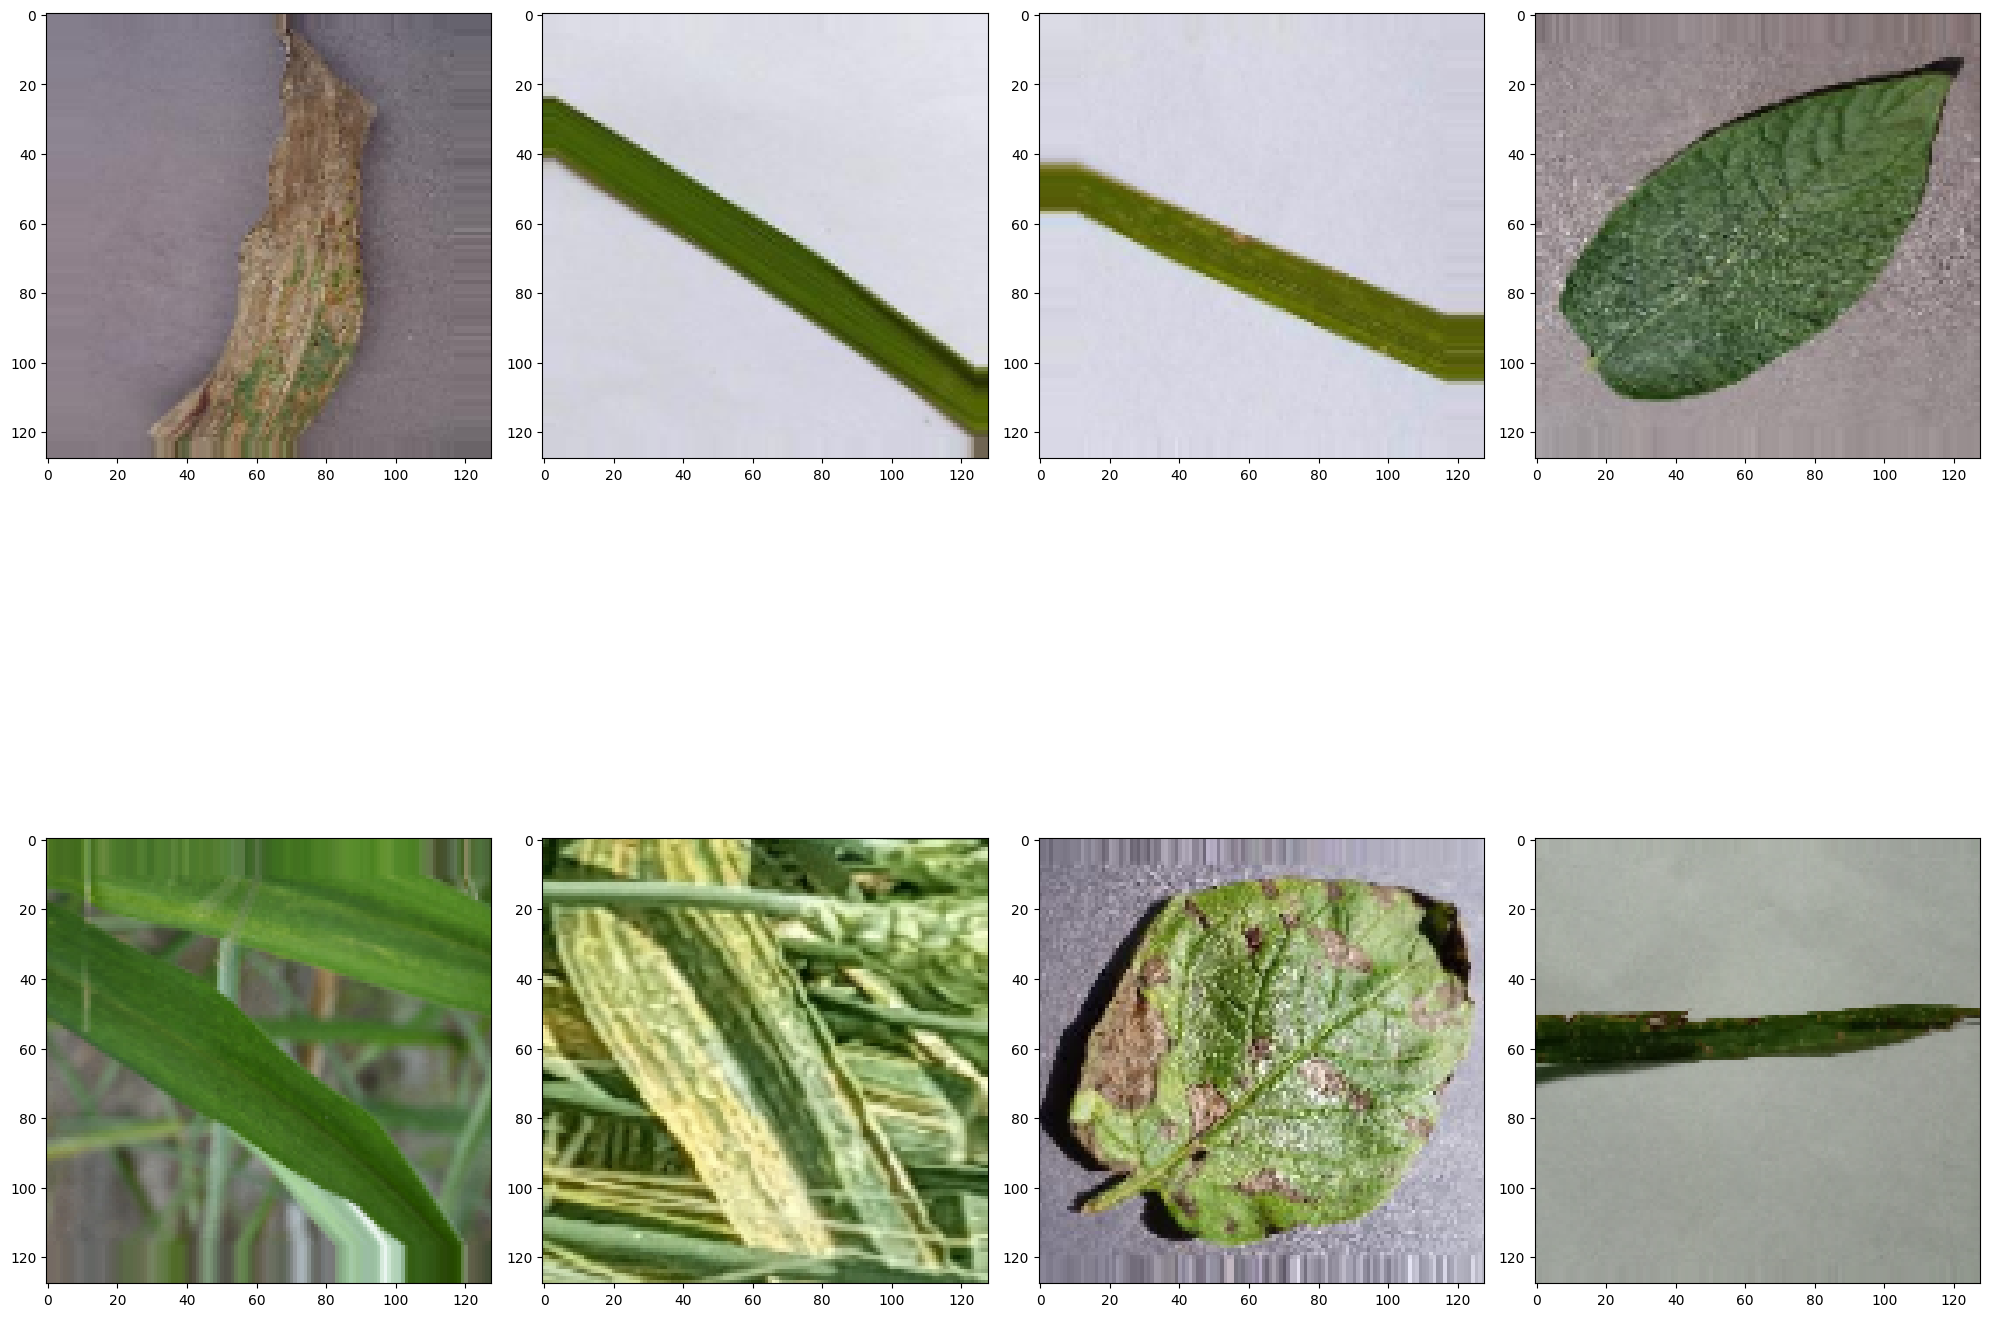

In [ ]:
def plot_images(images_arr):
    fig, axes = plt.subplots(2, 4, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('on')
    plt.tight_layout()
    plt.show()

# Get a batch of training images
images, labels = next(train_generator)
plot_images(images[:8])

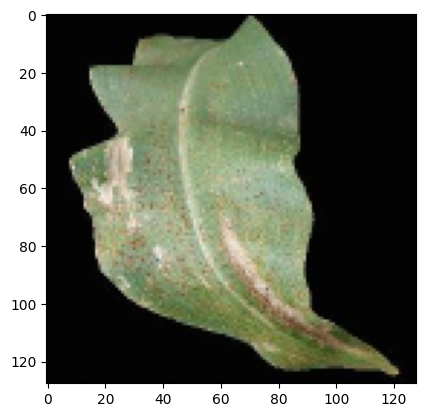

In [ ]:
img_path = '/content/Crop Diseases/Corn___Common_Rust/image (1).JPG'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128,128))
img = img / 255.0
plt.imshow(img)
plt.show()

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(64,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(32,activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(len(train_generator.class_indices), activation='softmax'))

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('model.h5', save_best_only=True, monitor='val_loss', mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

In [ ]:
history = model.fit(train_generator,
                    epochs = 60,
                    validation_data = validation_generator,
                    callbacks = callbacks)

Epoch 1/60
334/334 [==============================] - 274s 790ms/step - loss: 1.5344 - accuracy: 0.5228 - val_loss: 1.2728 - val_accuracy: 0.6004 - lr: 0.0010
Epoch 2/60


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


334/334 [==============================] - 204s 612ms/step - loss: 0.8923 - accuracy: 0.6980 - val_loss: 1.5116 - val_accuracy: 0.5650 - lr: 0.0010
Epoch 3/60
334/334 [==============================] - 199s 595ms/step - loss: 0.7407 - accuracy: 0.7350 - val_loss: 0.8605 - val_accuracy: 0.7180 - lr: 0.0010
Epoch 4/60
334/334 [==============================] - 197s 590ms/step - loss: 0.6673 - accuracy: 0.7649 - val_loss: 1.0096 - val_accuracy: 0.6801 - lr: 0.0010
Epoch 5/60
334/334 [==============================] - 204s 612ms/step - loss: 0.6387 - accuracy: 0.7653 - val_loss: 0.6778 - val_accuracy: 0.7436 - lr: 0.0010
Epoch 6/60
334/334 [==============================] - 197s 589ms/step - loss: 0.5706 - accuracy: 0.7923 - val_loss: 0.9185 - val_accuracy: 0.7312 - lr: 0.0010
Epoch 7/60
334/334 [==============================] - 194s 582ms/step - loss: 0.5488 - accuracy: 0.7981 - val_loss: 0.5820 - val_accuracy: 0.7906 - lr: 0.0010
Epoch 8/60
334/334 [==============================] - 201

In [ ]:
from google.colab import drive
from keras.models import load_model # Import the load_model function

# Attempt to mount Drive again after restarting runtime and clearing cache/cookies
drive.mount('/content/drive')

# Proceed with saving your model
model.save('/content/drive/My Drive/my_model.h5')
model = load_model('/content/drive/My Drive/my_model.h5')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


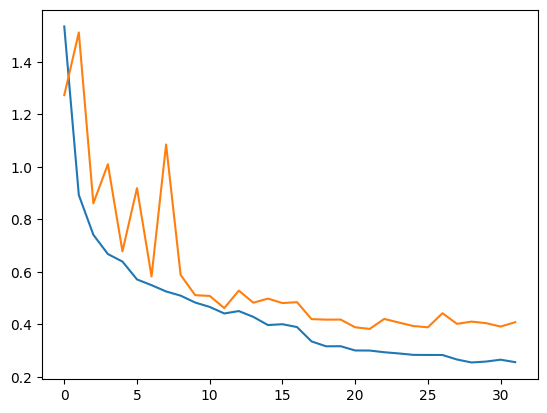

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

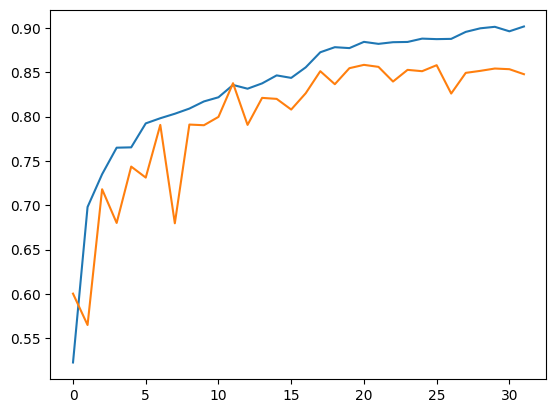

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])      #add metrics=['accuracy'] for this in model.compile

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

model1 = load_model('model.h5')

# Reshape img to match the expected input shape of the model
img = np.expand_dims(img, axis=0)  # Add a batch dimension

pred = model1.predict(img)

1/1 [==============================] - 0s 422ms/step


1/1 [==============================] - 0s 19ms/step
The model predicts that the image is: Potato___Healthy


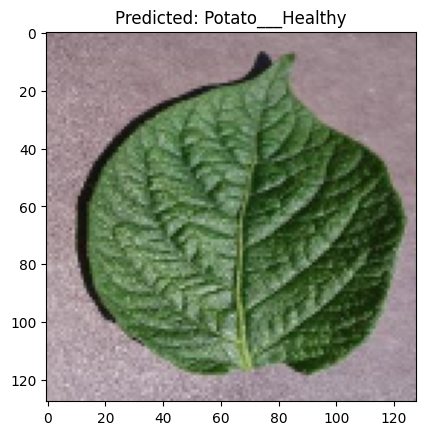

In [ ]:
# Function to preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image


# Function to decode the predictions
def decode_predictions(preds, class_indices):
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = np.argmax(preds, axis=1)
    return class_labels[predicted_class[0]]

image_path = '/content/Crop Diseases/Potato___Healthy/00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG'


image = preprocess_image(image_path)
prediction = model1.predict(image)
predicted_class = decode_predictions(prediction, train_generator.class_indices)

print(f'The model predicts that the image is: {predicted_class}')

img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))
img = img / 255.0
plt.imshow(img)
plt.title(f'Predicted: {predicted_class}')
plt.axis('on')
plt.show()

1/1 [==============================] - 0s 18ms/step
The model predicts that the image is: Corn___Common_Rust


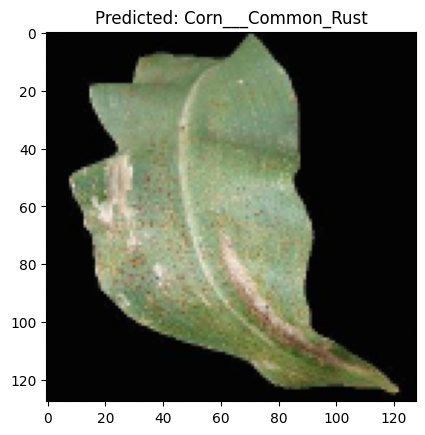

1/1 [==============================] - 0s 19ms/step
The model predicts that the image is: Corn___Gray_Leaf_Spot


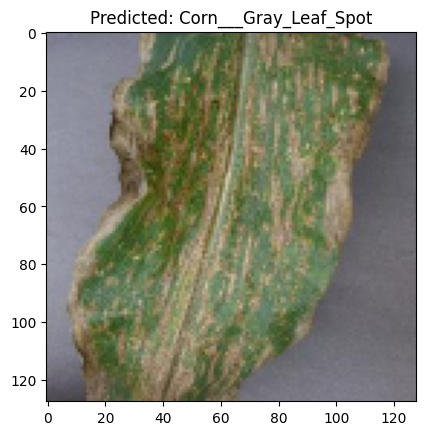

1/1 [==============================] - 0s 17ms/step
The model predicts that the image is: Corn___Healthy


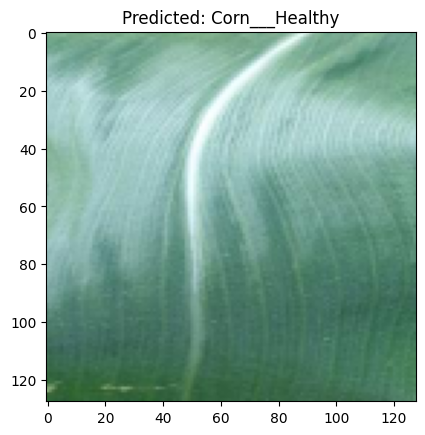

1/1 [==============================] - 0s 20ms/step
The model predicts that the image is: Corn___Northern_Leaf_Blight


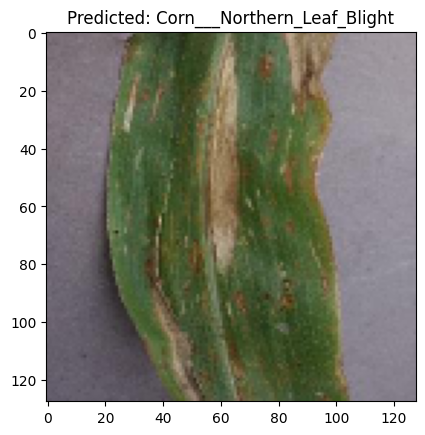

1/1 [==============================] - 0s 18ms/step
The model predicts that the image is: Potato___Early_Blight


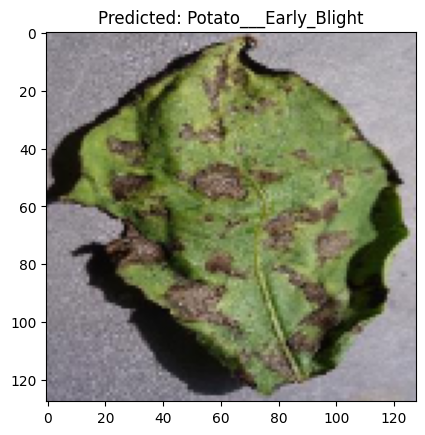

1/1 [==============================] - 0s 18ms/step
The model predicts that the image is: Potato___Healthy


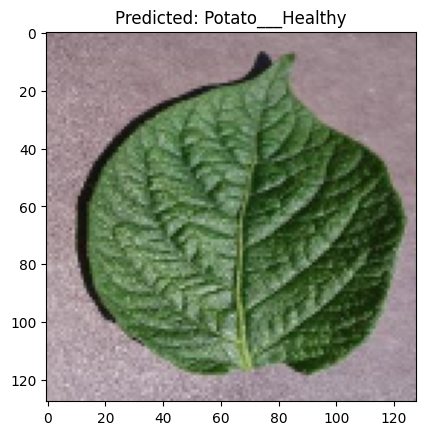

1/1 [==============================] - 0s 18ms/step
The model predicts that the image is: Potato___Late_Blight


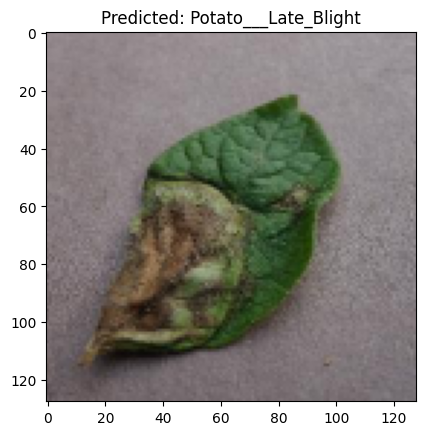

1/1 [==============================] - 0s 19ms/step
The model predicts that the image is: Rice___Healthy


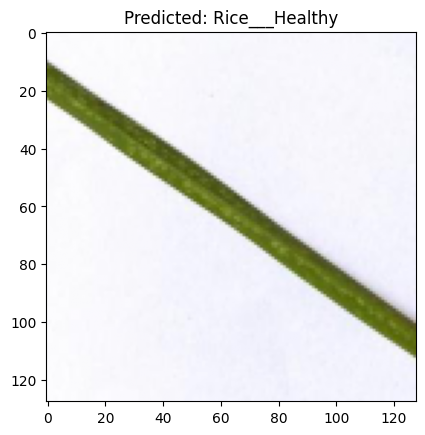

1/1 [==============================] - 0s 17ms/step
The model predicts that the image is: Rice___Healthy


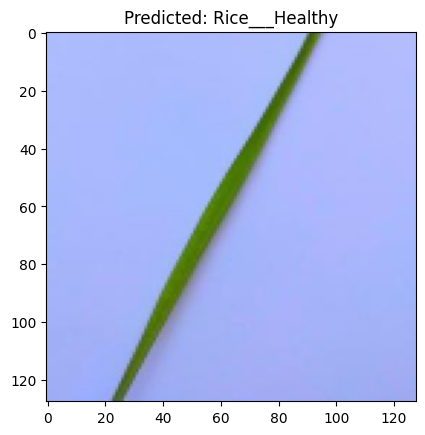

1/1 [==============================] - 0s 17ms/step
The model predicts that the image is: Rice___Leaf_Blast


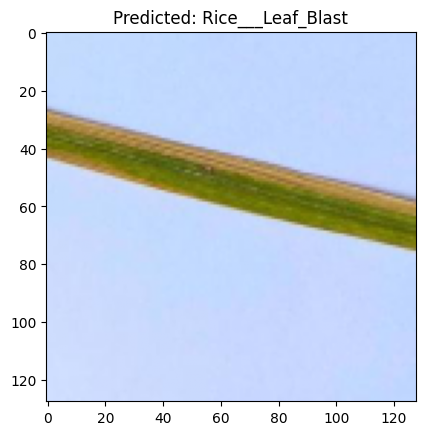

1/1 [==============================] - 0s 21ms/step
The model predicts that the image is: Wheat___Healthy


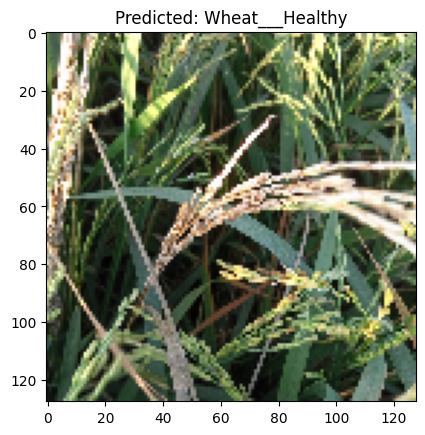

In [ ]:
# Function to preprocess the image
def preprocess_image(image_path):
    image = cv2.imread(i)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128, 128))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)
    return image


# Function to decode the predictions
def decode_predictions(preds, class_indices):
    class_labels = {v: k for k, v in class_indices.items()}
    predicted_class = np.argmax(preds, axis=1)
    return class_labels[predicted_class[0]]

image_path = ['/content/Crop Diseases/Corn___Common_Rust/image (1).JPG',
              '/content/Crop Diseases/Corn___Gray_Leaf_Spot/image (1).JPG',
              '/content/Crop Diseases/Corn___Healthy/image (1).jpg',
              '/content/Crop Diseases/Corn___Northern_Leaf_Blight/image (1).JPG',
              '/content/Crop Diseases/Potato___Early_Blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG',
              '/content/Crop Diseases/Potato___Healthy/00fc2ee5-729f-4757-8aeb-65c3355874f2___RS_HL 1864.JPG',
              '/content/Crop Diseases/Potato___Late_Blight/0051e5e8-d1c4-4a84-bf3a-a426cdad6285___RS_LB 4640.JPG',
              '/content/Crop Diseases/Rice___Brown_Spot/IMG_20190419_095712.jpg',
              '/content/Crop Diseases/Rice___Healthy/IMG_20190419_094251.jpg',
              '/content/Crop Diseases/Rice___Leaf_Blast/IMG_20190419_095029.jpg',
              '/content/Crop Diseases/Rice___Neck_Blast/IMG20201108163458_00.jpg']


for i in image_path:
  image = preprocess_image(i)
  prediction = model1.predict(image)
  predicted_class = decode_predictions(prediction, train_generator.class_indices)

  print(f'The model predicts that the image is: {predicted_class}')

  img = cv2.imread(i)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (128, 128))
  img = img / 255.0
  plt.imshow(img)
  plt.title(f'Predicted: {predicted_class}')
  plt.axis('on')
  plt.show()